In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [3]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
model_version = 'v15.0'

In [5]:
with open('../data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [6]:
df = pd.read_csv(f"../data/processed/spectrometry_photometry.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 2
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 4
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_Model')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Use Huber loss to balance sensitivity to outliers
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 24)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                1600      
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 Dense_256 (Dense)           (None, 256)               33024     
                                                                 
 Dropout_256 (Dropout)       (None, 256)          

In [10]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.5,
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
1222/1222 [==============================] - 10s 7ms/step - loss: 9.6092 - mae: 1.2698 - mse: 9.1714 - mape: 12.0683 - val_loss: 0.5016 - val_mae: 0.2452 - val_mse: 0.1043 - val_mape: 2.3293
Epoch 2/200
1222/1222 [==============================] - 9s 7ms/step - loss: 1.3227 - mae: 0.7241 - mse: 0.9514 - mape: 6.8636 - val_loss: 0.3926 - val_mae: 0.1467 - val_mse: 0.0467 - val_mape: 1.4167
Epoch 3/200
1222/1222 [==============================] - 9s 7ms/step - loss: 0.9577 - mae: 0.6311 - mse: 0.6356 - mape: 5.9795 - val_loss: 0.3366 - val_mae: 0.1260 - val_mse: 0.0386 - val_mape: 1.2233
Epoch 4/200
1222/1222 [==============================] - 9s 7ms/step - loss: 0.8559 - mae: 0.5927 - mse: 0.5756 - mape: 5.6181 - val_loss: 0.2950 - val_mae: 0.1138 - val_mse: 0.0340 - val_mape: 1.1161
Epoch 5/200
1222/1222 [==============================] - 9s 7ms/step - loss: 0.7815 - mae: 0.5594 - mse: 0.5368 - mape: 5.3033 - val_loss: 0.2633 - val_mae: 0.1145 - val_mse: 0.0341 - val_mape: 

In [11]:
model.save(f'../models/{model_version}/photo_no_transfer_model.h5')

In [12]:
save_history(history, model_version)

In [13]:
y_pred_full = model.predict(X_test_scaled)

2094/2094 [==============================] - 3s 1ms/step


In [14]:
plot_metrics(y_test, y_pred_full)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0794
Root Mean Squared Error (RMSE): 0.1535
R² Score: 0.9454


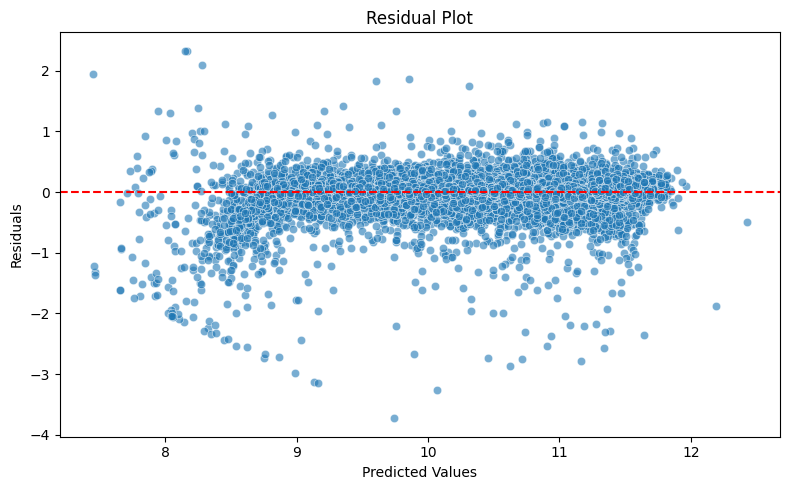

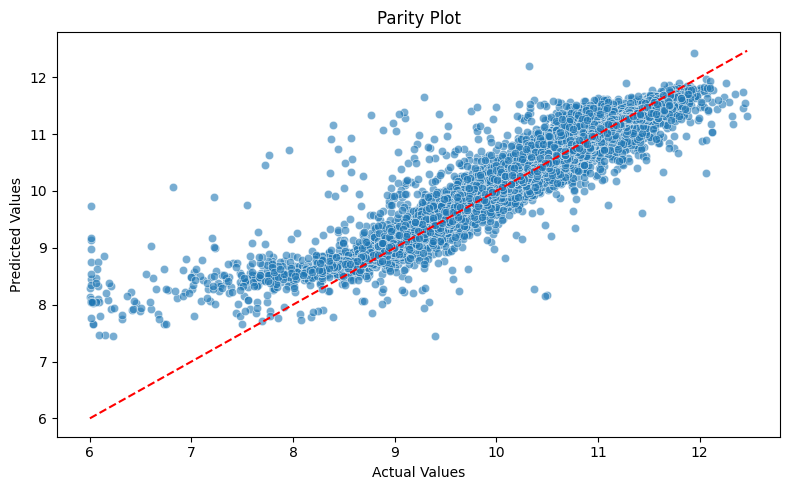

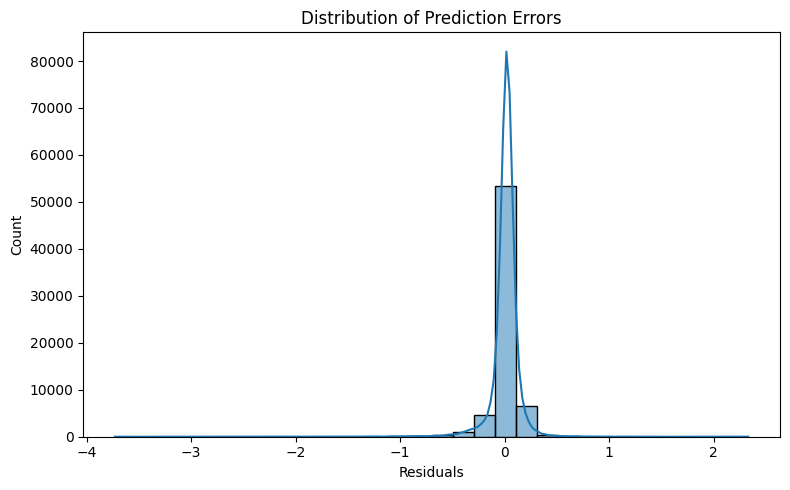

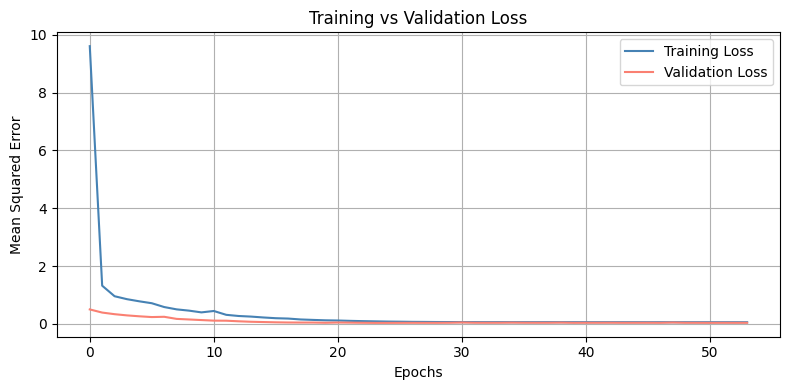

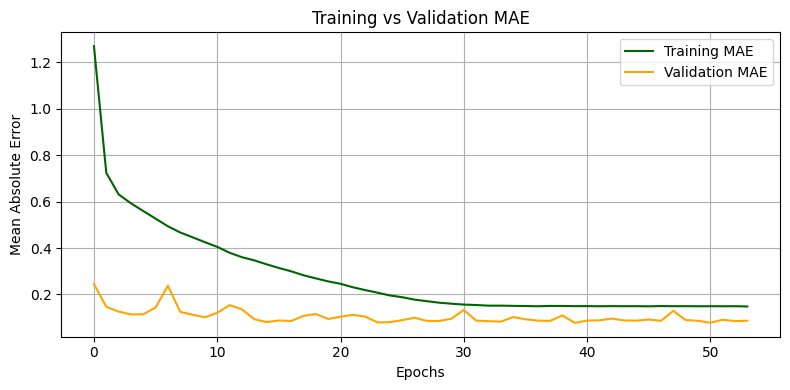

In [15]:
plot_visualizations(history, y_test, y_pred_full)

In [16]:
df_unseen = pd.read_csv(f"../data/processed/unseen_data.csv")

X_unseen = df_unseen[spectro_cols + photo_cols + generic_cols]
y_unseen = df_unseen[target_col]

In [17]:
X_unseen_scaled = scaler.transform(X_unseen)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- d4000
- d4000_n
- h_alpha_flux
- h_beta_flux
- h_delta_eqw
- ...


In [ ]:
y_pred_unseen = model.predict(X_unseen_scaled)

In [ ]:
plot_metrics(y_unseen, y_pred_unseen)

In [ ]:
plot_visualizations(history, y_unseen, y_pred_unseen)